# Big Data in Finance: Part II <BR><BR> Lecture Notes 9: Compustat 
    
**Instructor** <BR>
Lira Mota, lmota20@gsb.columbia.edu
    
**TA's:** <BR>
Meha Sadasivam, MSadasivam21@gsb.columbia.edu <BR>
Daheng Yang, dyang22@gsb.columbia.edu

# Compustat

In this section we are going to:
1. Download a set of US firm's annual fundamentals;
2. Understand how the data is organized:
    1. Primary keys;
    2. Secondary keys;
    3. Data frequency;
    4. Others.        
2. Clean the data;
3. Construct important variables:
    1. Book Equity Value
    2. Asset Growth
    3. Operational Profitability

## How is the fundamentals data organized?

* We can display all tables in "compm" library.
* We are going to focus on the "funda" table: annual fundamentals.
* Others that are interesting to know: "namesd"

## Set Up

In [1]:
%matplotlib inline 

#%% Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 200) # max number or rows to be displayed 

In [2]:
#%% Set WRDS Connection
db = wrds.Connection(wrds_username='lmota') # make sure to configure wrds connector before hand.

Loading library list...
Done


### All tables in compm

In [3]:
compm_tables = db.list_tables(library="comp") # compd: Compustat daily update 

In [4]:
 pd.DataFrame({'tables':compm_tables}).head(100) # Transform libs to a Pandas data frame to have a better display.

tables
0          aco_amda
1          aco_imda
2       aco_indfnta
3       aco_indfntq
4     aco_indfntytd
5        aco_indsta
6        aco_indstq
7      aco_indstytd
8        aco_notesa
9        aco_notesq
10      aco_notessa
11     aco_notesytd
12       aco_pnfnda
13       aco_pnfndq
14     aco_pnfndytd
15       aco_pnfnta
16       aco_pnfntq
17     aco_pnfntytd
18       aco_transa
19       aco_transq
20      aco_transsa
21     aco_transytd
22         adsprate
23        asec_amda
24        asec_imda
25      asec_notesa
26      asec_notesq
27      asec_transa
28      asec_transq
29    bank_aacctchg
30     bank_adesind
31       bank_afnd1
32       bank_afnd2
33     bank_afnddc1
34     bank_afnddc2
35     bank_afntind
36       bank_funda
37  bank_funda_fncd
38       bank_fundq
39  bank_fundq_fncd
40    bank_iacctchg
41     bank_idesind
42       bank_ifndq
43     bank_ifndytd
44       bank_ifntq
45     bank_ifntytd
46       bank_names
47      bank_namesq
48            chars
49      co_aacctchg
50        co_aaudit
51       co_adesind
52       co_adjfact
53         co_afnd1
54         co_afnd2
55       co_afnddc1
56       co_afnddc2
57      co_afntind1
58      co_afntind2
59       co_ainvval
60          co_amkt
61      co_busdescl
62        co_cotype
63      co_filedate
64       co_fortune
65          co_hgic
66      co_iacctchg
67        co_iaudit
68       co_idesind
69         co_ifndq
70        co_ifndsa
71       co_ifndytd
72         co_ifntq
73        co_ifntsa
74       co_ifntytd
75          co_imkt
76      co_industry
77          co_ipcd
78         co_mthly
79       co_offtitl
80          company
81         currency
82         dd_group
83    dd_group_xref
84          dd_item
85       dd_package
86       ecind_desc
87        ecind_mth
88         exrt_dly
89         exrt_mth
90          filings
91            funda
92       funda_fncd
93            fundq
94       fundq_fncd
95          g_chars
96      g_co_aaudit
97     g_co_adesind
98       g_co_afnd1
99       g_co_afnd2

### All variables in compm.funda

In [5]:
db.describe_table(library="comp", table="funda")

Approximately 832557 rows in comp.funda.


name  nullable              type
0       gvkey      True       VARCHAR(24)
1    datadate      True              DATE
2       fyear      True  DOUBLE_PRECISION
3      indfmt      True       VARCHAR(48)
4      consol      True        VARCHAR(8)
..        ...       ...               ...
943        au      True       VARCHAR(32)
944      auop      True       VARCHAR(32)
945    auopic      True        VARCHAR(4)
946     ceoso      True        VARCHAR(4)
947     cfoso      True        VARCHAR(4)

[948 rows x 3 columns]

#### Where to check variable definitions?
1. [Xpressfeed Data Items](https://wrds-web.wharton.upenn.edu/wrds/support/Data/_001Manuals%20and%20Overviews/_001Compustat/_001North%20America%20-%20Global%20-%20Bank/_000dataguide/index.cfm?_ga=2.238205512.977702200.1550764493-1500651139.1501534854)
2. WRDS website: go to the (?) sign
3. What if we want to replicate a paper that says:

   "Earnings (E) is income before extraordinary items (Item 18) plus income statement deferred taxes (Item 50) minus preferred dividends (Item 19), if earnings are positive;" [Baker and Wurgler, JF 2006](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1540-6261.2006.00885.x)

    * All previous documentation does not contain ITEM numbers
    * These are the legacy CST item numbers
    * You can find item reference [here](http://www.crsp.com/products/documentation/annual-data-industrial).
    
    

**Objective**

Create a data frame with company fundamentals necessary to replicate FF 2015:

1. Book Equity (BE)
2. Operating Profits (OP)
3. Investment (INV)

# Choose variables of interest

Compustat XpressFeed Variables 1/5:  
* AT      = Total Assets  
* CAPX    = Capital Expenditures  
* CEQ     = Common/Ordinary Equity - Total 
* COGS    = Cost of Goods Sold
* CSHO    = Common Shares Outstanding
* DLC     = Debt in Current Liabilities 
* DLCCH   = Current Debt - Changes
* DLTT    = Long-Term Debt - Total

Compustat XpressFeed Variables 2/5:
* DP      = Depreciation and Amortization
* DVC     = Divdends common/ordinary  
* DVP     = Dividends - Preferred/Preference
* GP      = Gross Profits
* IB      = Income Before Extraordinary Items
* ICAPT   = Invested Capital - Total
* ITCB    = Investment Tax Credit (Balance Sheet)  
* LT      = Total Liabilities

Compustat XpressFeed Variables 3/5:
* MIB     = Minority Interest (Balance Sheet)
* NAICS   = North American Industrial Classification System Variable Name
* NAICSH  = North American Industry Classification Codes - Historical Company Variable Name
* NI      = Net Income
* PPEGT   = "Property, Plant and Equipment - Total (Gross)"
* PRBA    = Postretirement Benefit Assets (from separate pension annual file) 
* PRSTKCC = Purchase of Common Stock (Cash Flow)                   
* PSTKRV  = Preferred Stock Redemption Value

Compustat XpressFeed Variables 4/5:
* PSTK    = Preferred/Preference Stock (Capital) - Total (kd: = par?)               
* PSTKL   = Preferred Stock Liquidating Value     
* PSTKRV  = Preferred Stock Liquidating Value          
* RE      = Retained Earnings
* REVT    = Revenue - Total
* SALE    = Sales/Turnover Net
* SEQ     = Shareholders Equity   
* SIC     = Standard Industrial Classification Code

Compustat XpressFeed Variables 5/5:
* TXDB    = Deferred Taxes Balance Sheet
* TXDI    = Income Taxes - Deferred
* TXDITC  = Deferred Taxes and Investment Tax Credit                        
* WCAPCH  = Working Capital Change - Total
* XINT    = Interest and Related Expense - Total 
* XLR     = Staff Expense - Total
* XRD     = Research and Development Expense 
* XSGAQ   = Selling, General and Administrative Expenses (millions)  

# Download Compustat FUNDA

In [6]:
fund_table = 'funda'

varlist = ['conm', 'tic', 'cusip','fyear', 'fyr', 'at','capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch','dltt', 'dp', 'ib', 'itcb', 
           'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt', 'sale', 
           'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint', 'xlr', 'xrd', 'xsga']


query = """SELECT gvkey, datadate, {}
           FROM comp.{}
           WHERE datafmt = 'STD'
           AND popsrc = 'D'
           AND indfmt = 'INDL'
           AND consol = 'C'
           AND fyear>=1980;""".format(", ".join(varlist), fund_table)

compa = db.raw_sql(query, date_cols=['datadate'])

del(fund_table, varlist, query)

Always look at your data

In [7]:
# Gerneral Look
compa.head()  

gvkey   datadate                     conm    tic      cusip   fyear   fyr  \
0  001001 1980-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1980.0  12.0   
1  001001 1981-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1981.0  12.0   
2  001001 1982-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1982.0  12.0   
3  001001 1983-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1983.0  12.0   
4  001001 1984-12-31  A & M FOOD SERVICES INC  AMFD.  000165100  1984.0  12.0   

       at   capx    ceq  ...    seq  sich   txdb   txdi  txditc  wcapch  \
0     NaN    NaN    NaN  ...    NaN   NaN    NaN    NaN     NaN     NaN   
1     NaN    NaN    NaN  ...    NaN   NaN    NaN    NaN     NaN     NaN   
2     NaN    NaN    NaN  ...    NaN   NaN    NaN    NaN     NaN     NaN   
3  14.080  3.367  7.823  ...  7.823   NaN  0.000  0.144   0.000   3.618   
4  16.267  5.496  8.962  ...  8.962   NaN  0.357  0.275   0.357  -2.993   

    xint  xlr  xrd    xsga  
0    NaN  NaN  NaN     NaN  
1    NaN  NaN  NaN     NaN  
2    NaN  NaN  NaN     NaN  
3  0.763  NaN  0.0  16.435  
4  0.661  NaN  NaN  20.628  

[5 rows x 39 columns]

In [8]:
# Have a sense about missings
compa['at'].isnull().mean()*100

15.997164132766779

In [9]:
compa.gvkey.nunique()

38411

In [10]:
compa.groupby('fyear').gvkey.nunique()

fyear
1980.0     6889
1981.0     7058
1982.0     7685
1983.0     7996
1984.0     8243
1985.0     8599
1986.0     9017
1987.0     9225
1988.0     9333
1989.0     9343
1990.0     9571
1991.0     9966
1992.0    10705
1993.0    11482
1994.0    11899
1995.0    12492
1996.0    12624
1997.0    12438
1998.0    12555
1999.0    12531
2000.0    12093
2001.0    11584
2002.0    11251
2003.0    11064
2004.0    10898
2005.0    10854
2006.0    10876
2007.0    10870
2008.0    10681
2009.0    10632
2010.0    10936
2011.0    11614
2012.0    11832
2013.0    11826
2014.0    11630
2015.0    11458
2016.0    11306
2017.0    11218
2018.0    11169
2019.0    10809
2020.0     7360
Name: gvkey, dtype: int64

# Data Consistency 

## Primary Keys


* We are looking at Annual data
* Logic says that that we should have one company (gvkey) per year (fyear)
* But remember, the primary key for funda is (gvkey and datadate)
* Question: Can a firm have two datadate for the same year?


In [11]:
# It is always good to check if we have the right PK
compa.duplicated(['gvkey', 'datadate']).sum()

0

In [12]:
# Is (gvkey, fyear) PK?
compa[compa.duplicated(['gvkey', 'fyear'])]

gvkey   datadate                       conm   tic      cusip   fyear  \
65371  006557 1982-12-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1982.0   
65373  006557 1983-12-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1983.0   

        fyr  at  capx  ceq  ...  seq  sich  txdb  txdi  txditc  wcapch  xint  \
65371  12.0 NaN   NaN  NaN  ...  NaN   NaN   NaN   NaN     NaN     NaN   NaN   
65373  12.0 NaN   NaN  NaN  ...  NaN   NaN   NaN   NaN     NaN     NaN   NaN   

       xlr  xrd  xsga  
65371  NaN  NaN   NaN  
65373  NaN  NaN   NaN  

[2 rows x 39 columns]

In [13]:
compa[compa.gvkey=='006557']

gvkey   datadate                       conm   tic      cusip   fyear  \
65368  006557 1980-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1980.0   
65369  006557 1981-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1981.0   
65370  006557 1982-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1982.0   
65371  006557 1982-12-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1982.0   
65372  006557 1983-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1983.0   
65373  006557 1983-12-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1983.0   
65374  006557 1984-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1984.0   
65375  006557 1985-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1985.0   
65376  006557 1986-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1986.0   
65377  006557 1987-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1987.0   
65378  006557 1988-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1988.0   
65379  006557 1989-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1989.0   
65380  006557 1990-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1990.0   
65381  006557 1991-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1991.0   
65382  006557 1992-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1992.0   
65383  006557 1993-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1993.0   
65384  006557 1994-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1994.0   
65385  006557 1995-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1995.0   
65386  006557 1996-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1996.0   
65387  006557 1997-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1997.0   
65388  006557 1998-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1998.0   
65389  006557 1999-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1999.0   
65390  006557 2000-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  2000.0   
65391  006557 2001-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  2001.0   
65392  006557 2002-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  2002.0   
65393  006557 2003-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  2003.0   
65394  006557 2004-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  2004.0   
65395  006557 2005-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  2005.0   
65396  006557 2006-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  2006.0   

        fyr        at     capx       ceq  ...       seq    sich     txdb  \
65368   8.0   201.266   38.344    50.957  ...    73.039     NaN   14.636   
65369   8.0   242.081   53.382    59.995  ...    81.481     NaN   18.192   
65370   8.0   251.360   47.089    63.491  ...    84.314     NaN   19.938   
65371  12.0       NaN      NaN       NaN  ...       NaN     NaN      NaN   
65372   8.0   328.891   78.264   103.481  ...   120.161     NaN   25.469   
65373  12.0       NaN      NaN       NaN  ...       NaN     NaN      NaN   
65374   8.0   426.880   93.098   177.188  ...   191.757     NaN   31.525   
65375   8.0   652.477  149.695   225.685  ...   357.124     NaN   34.765   
65376   8.0   901.769  149.687   406.137  ...   537.574     NaN   36.442   
65377   8.0  1655.019  242.522   821.060  ...  1138.647  4953.0   38.797   
65378   8.0  1636.927  244.666   755.048  ...   906.630  4953.0   43.807   
65379   8.0  2651.276  187.868  1330.093  ...  1477.194  4953.0   63.812   
65380   8.0  3894.939  271.309  1906.825  ...  2053.867  4953.0   88.617   
65381   8.0  3595.316  248.448  1672.454  ...  1682.063  4953.0   89.781   
65382   8.0  3658.935  208.723  1950.345  ...  1959.954  4953.0   88.800   
65383   8.0  3575.082  200.712  1543.701  ...  1553.310  4953.0   43.904   
65384   8.0  3633.200  273.000  1576.300  ...  1585.900  4953.0   48.200   
65385   8.0  4286.300  316.700  1688.100  ...  1697.400  4953.0   46.000   
65386   8.0  4932.300  289.100  2127.800  ...  2136.800  4100.0  131.500   
65387   8.0  6117.100  237.100  2785.300  ...  2794.000  4100.0   52.900   
65388   8.0

In [14]:
# Check duplicates
compa[compa.duplicated(['gvkey', 'fyear'],keep='last')]

gvkey   datadate                       conm   tic      cusip   fyear  \
65370  006557 1982-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1982.0   
65372  006557 1983-08-31  LAIDLAW INTERNATIONAL INC  LI.3  50730R102  1983.0   

       fyr       at    capx      ceq  ...      seq  sich    txdb   txdi  \
65370  8.0  251.360  47.089   63.491  ...   84.314   NaN  19.938  2.672   
65372  8.0  328.891  78.264  103.481  ...  120.161   NaN  25.469  5.533   

       txditc  wcapch    xint  xlr  xrd    xsga  
65370  19.938  13.777  14.309  NaN  NaN     NaN  
65372  25.469   3.109   8.879  NaN  NaN  17.218  

[2 rows x 39 columns]

In [15]:
# Example of a company that have two reports for the same year
compa.loc[compa.gvkey=='006557',['gvkey','datadate','fyear','fyr','conm', 'at']]

gvkey   datadate   fyear   fyr                       conm        at
65368  006557 1980-08-31  1980.0   8.0  LAIDLAW INTERNATIONAL INC   201.266
65369  006557 1981-08-31  1981.0   8.0  LAIDLAW INTERNATIONAL INC   242.081
65370  006557 1982-08-31  1982.0   8.0  LAIDLAW INTERNATIONAL INC   251.360
65371  006557 1982-12-31  1982.0  12.0  LAIDLAW INTERNATIONAL INC       NaN
65372  006557 1983-08-31  1983.0   8.0  LAIDLAW INTERNATIONAL INC   328.891
65373  006557 1983-12-31  1983.0  12.0  LAIDLAW INTERNATIONAL INC       NaN
65374  006557 1984-08-31  1984.0   8.0  LAIDLAW INTERNATIONAL INC   426.880
65375  006557 1985-08-31  1985.0   8.0  LAIDLAW INTERNATIONAL INC   652.477
65376  006557 1986-08-31  1986.0   8.0  LAIDLAW INTERNATIONAL INC   901.769
65377  006557 1987-08-31  1987.0   8.0  LAIDLAW INTERNATIONAL INC  1655.019
65378  006557 1988-08-31  1988.0   8.0  LAIDLAW INTERNATIONAL INC  1636.927
65379  006557 1989-08-31  1989.0   8.0  LAIDLAW INTERNATIONAL INC  2651.276
65380  006557 1990-08-31  1990.0   8.0  LAIDLAW INTERNATIONAL INC  3894.939
65381  006557 1991-08-31  1991.0   8.0  LAIDLAW INTERNATIONAL INC  3595.316
65382  006557 1992-08-31  1992.0   8.0  LAIDLAW INTERNATIONAL INC  3658.935
65383  006557 1993-08-31  1993.0   8.0  LAIDLAW INTERNATIONAL INC  3575.082
65384  006557 1994-08-31  1994.0   8.0  LAIDLAW INTERNATIONAL INC  3633.200
65385  006557 1995-08-31  1995.0   8.0  LAIDLAW INTERNATIONAL INC  4286.300
65386  006557 1996-08-31  1996.0   8.0  LAIDLAW INTERNATIONAL INC  4932.300
65387  006557 1997-08-31  1997.0   8.0  LAIDLAW INTERNATIONAL INC  6117.100
65388  006557 1998-08-31  1998.0   8.0  LAIDLAW INTERNATIONAL INC  6184.600
65389  006557 1999-08-31  1999.0   8.0  LAIDLAW INTERNATIONAL INC  5754.300
65390  006557 2000-08-31  2000.0   8.0  LAIDLAW INTERNATIONAL INC  4000.100
65391  006557 2001-08-31  2001.0   8.0  LAIDLAW INTERNATIONAL INC  4209.800
65392  006557 2002-08-31  2002.0   8.0  LAIDLAW INTERNATIONAL INC  4091.100
65393  006557 2003-08-31  2003.0   8.0  LAIDLAW INTERNATIONAL INC  3852.700
65394  006557 2004-08-31  2004.0   8.0  LAIDLAW INTERNATIONAL INC  3905.200
65395  006557 2005-08-31  2005.0   8.0  LAIDLAW INTERNATIONAL INC  2908.700
65396  006557 2006-08-31  2006.0   8.0  LAIDLAW INTERNATIONAL INC  3038.700

In [16]:
# How to deal with duplicates? Keep last available entry (datadate)
compa.dropna(subset=['fyear'], inplace=True)
compa.sort_values(['gvkey','fyear','at'], inplace=True)
compa = compa[~compa.duplicated(['gvkey', 'fyear'], keep='first')]

In [17]:
# Always check your result
compa.duplicated(['gvkey', 'fyear']).sum()

0

# Calculate Variables of Interest

## Book Equity

Daniel, Mota, Rottke, Santos (RFS, 2020) BE definition:

Stockholders book equity, minus the book value of preferred stock, plus balance sheet deferred taxes (if available and fiscal year is < 1993), minus investment tax credit (if available), minus post-retirement benefit assets (PRBA) if available. 

Stockholders book equity is shareholder equity (SEQ), common equity (CEQ) plus preferred stock (PSTK) or total
assets (AT) minus liabilities (LT) plus minority interest (MIB, if available) (depending on availability, in that order). 

Book value of preferred stock is redemption (PSTKRV), liquidation (PSTKL), or par value (PSTK) (depending on availability, in that order). 

Deferred taxes is deferred taxes and investment tax credit (TXDITC) or deferred taxes and investment tax credit (TXDB) plus investment tax credit (ITCB) (depending on availability, in that order).


In [18]:
#%% Calculating BE

# Shareholder Equity
compa['se'] = compa['seq']

# Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
compa['se'].fillna((compa['ceq'] + compa['pstk']), inplace=True)

# Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
compa['se'].fillna((compa['at'] - compa['lt'] + compa['mib'].fillna(0)), inplace=True)
  

In [19]:
# Preferred Stock
# Preferred Stock (Redemption Value)
compa['ps'] = compa['pstkrv']
# Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing
compa['ps'].fillna(compa['pstkl'], inplace=True)
# Uses Preferred Stock (Carrying Value (pstk)) if others are missing
compa['ps'].fillna(compa['pstk'], inplace=True)

In [20]:
# Deferred Taxes
# Uses Deferred Taxes and Investment Tax Credit (txditc)
compa['dt'] = compa['txditc']

# This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
# Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing
compa['dt'].fillna((compa['txdb'].fillna(0) + compa['itcb'].fillna(0)), inplace=True)
# If all measures are missing, set n  to missing
compa.loc[pd.isnull(compa['txditc']) & pd.isnull(compa['txdb']) & pd.isnull(compa['itcb']), 'dt'] = np.nan

compa.loc[compa['fyear'] >= 1993, 'dt'] = 0

In [21]:
# Book Equity
# Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
compa['be'] = (compa['se']  # shareholder equity must be available, otherwise BE is missing
               - compa['ps']  # preferred stock must be available, otherwise BE is missing
               + compa['dt'].fillna(0))  # add deferred taxes if available
               #- compa['prba'].fillna(0))  # subtract postretirement benefit assets if available

**Always look at your data...**

In [22]:
# Missings
compa.be.isnull().mean()  

0.16170310371352048

<AxesSubplot:>

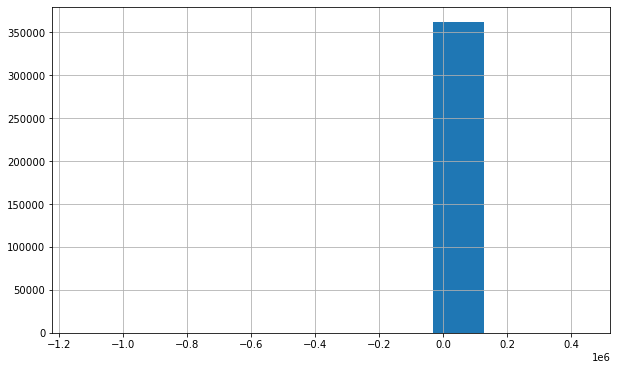

In [23]:
compa.be.hist() 

In [24]:
# Does it make sense to have a negative BE?
(compa.be<0).mean()   

0.09713353660231874

<AxesSubplot:>

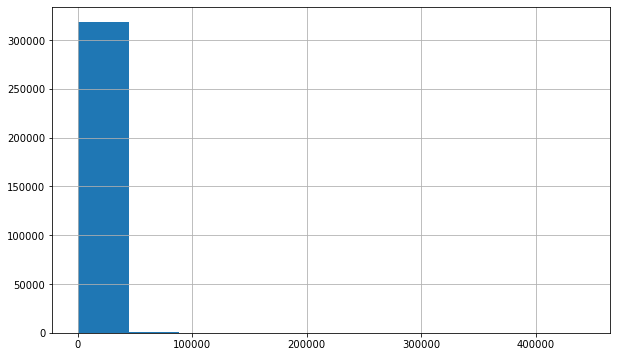

In [25]:
compa[compa.be>0].be.hist()

<AxesSubplot:>

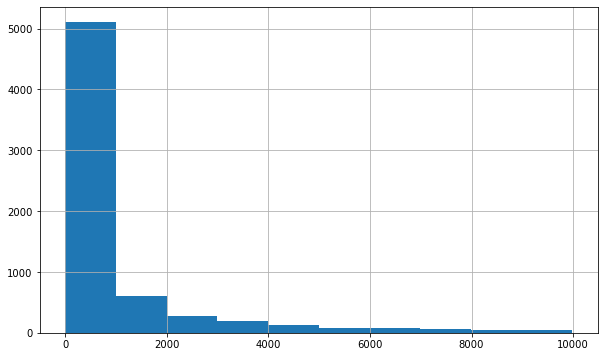

In [26]:
compa[(compa.be>0)&(compa.be<10e3)&(compa.fyear==2017)].be.hist()

## Operating Profitability (OPBE)

Daniel, Mota, Rottke, Santos (RFS, 2020) OPBE definition:

Operating profits to book equity (BE) ratio. 

Operating profits is sales (SALE) minus cost of goods sold (COGS), minus selling, general, and administrative expenses (XSGA),
minus interest expense (XINT). In order to be non-missing, SALE must be non-missing, at least one of the other entries must be non-missing and BE must be greater than zero.

In [27]:
# COST = COGS + XSGA + XINT 
compa['cost'] = compa[['cogs', 'xsga', 'xint']].sum(axis=1, skipna=True)
compa.loc[compa[['cogs', 'xsga', 'xint']].isnull().all(axis=1), 'cost'] = np.nan

In [28]:
# OP = SALE -COST    
compa['op'] = compa['sale']-compa['cost']

**Always look at your data...**

In [29]:
# Look at missings
compa.op.isnull().mean()

0.1658665653410934

<AxesSubplot:>

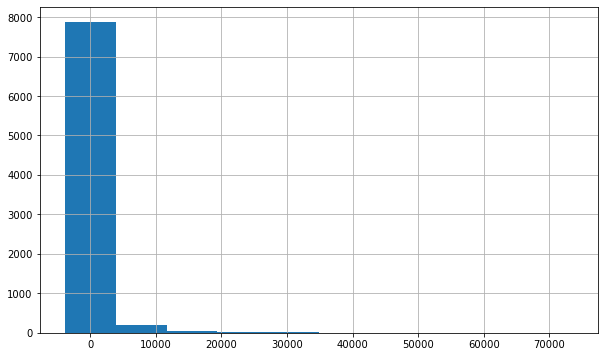

In [30]:
compa[compa.fyear==2017].op.hist()

In [31]:
# Which was the most profitable company in 2017?
compa.loc[compa[compa.fyear==2017].op.idxmax(),['gvkey','conm','op','be','at']]

gvkey         015532
conm     BNP PARIBAS
op         73500.106
be        122603.963
at       2356614.954
Name: 174829, dtype: object

<AxesSubplot:title={'center':"Apple's OP"}, xlabel='fyear'>

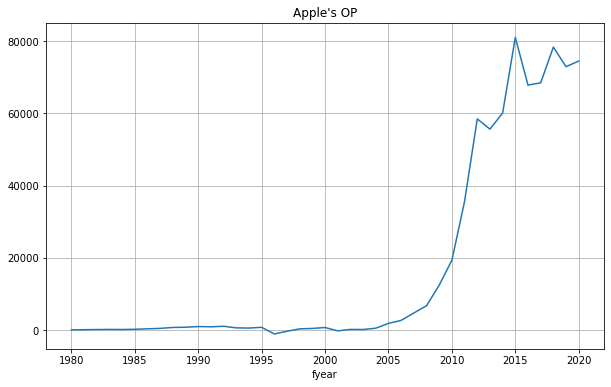

In [32]:
# Plot
compa[compa.gvkey=='001690'].set_index('fyear').op.plot(title = "Apple's OP", grid=True)

In [33]:
# Calculate OPBE
compa.loc[(compa.be > 0), 'opbe'] = compa['op']/compa['be']

**What do we do now?**

Look at the data...

In [34]:
# Look at missings
compa.opbe.isnull().mean()

0.26457327414437043

<AxesSubplot:>

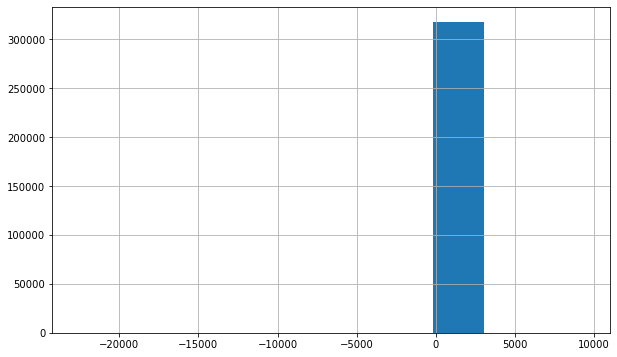

In [35]:
# Be careful with ratios
compa.opbe.hist()

<AxesSubplot:title={'center':"Apple's OPBE"}, xlabel='fyear'>

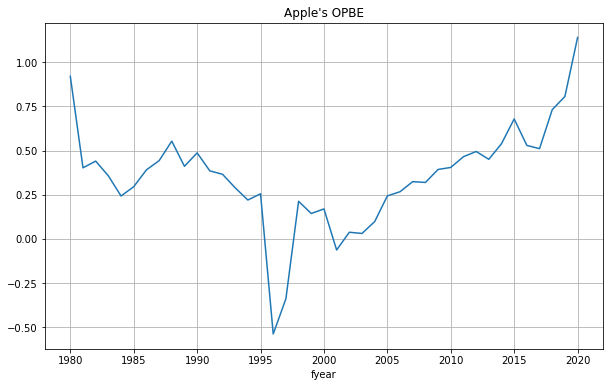

In [36]:
# Plot
compa[compa.gvkey=='001690'].set_index('fyear').opbe.plot(title = "Apple's OPBE", grid=True)

## Investment (INV)

Daniel, Mota, Rottke, Santos (RFS, 2020) OP definition:

Total asset (AT) growth $(AT_t/AT_{t-1} - 1)$. 

We consider PERMCO as company's identification key. AT must be greater than zero to be not missing.


In [37]:
# Calculate lag assets and investment
compa.sort_values(['gvkey', 'fyear'], inplace=True)
compa['at_lag'] = compa.groupby('gvkey').at.shift(1)
compa['inv'] = (compa['at'] - compa['at_lag']) / compa['at_lag']

In [38]:
compa.inv.max()

inf

In [39]:
compa.inv.min()

-1.0

In [40]:
compa.loc[compa.at_lag==0, 'inv'] = np.nan

What if compa has missing years?

In [41]:
compa['fdiff'] = compa.groupby('gvkey').fyear.diff()

In [42]:
compa[(compa.fdiff>1)][['gvkey','fyear','fdiff', 'at','at_lag', 'inv']]

gvkey   fyear  fdiff         at     at_lag        inv
21139   002820  2001.0    4.0    117.090        NaN        NaN
26993   003279  2011.0   19.0        NaN      1.269        NaN
29083   003469  2002.0    4.0    406.677        NaN        NaN
32534   003819  2011.0   19.0        NaN      2.295        NaN
35607   004049  2000.0    4.0    905.890        NaN        NaN
39248   004341  2000.0    2.0      0.000        NaN        NaN
40005   004412  2004.0    2.0    213.432    218.681  -0.024003
40008   004412  2008.0    2.0    219.640    203.755   0.077961
43650   004707  1996.0    3.0     14.416        NaN        NaN
49302   005202  1999.0   14.0      0.000      0.102  -1.000000
54646   005681  1995.0    4.0     26.851  13885.098  -0.998066
55902   005792  1998.0   13.0    218.462     84.850   1.574685
56359   005835  1997.0   16.0      0.030      3.052  -0.990170
58245   006000  2010.0   20.0        NaN      6.091        NaN
63696   006423  2011.0   22.0        NaN     38.823        NaN
64162   006464  1998.0   13.0      0.027      1.553  -0.982614
70971   007102  2011.0   19.0        NaN      1.687        NaN
72129   007185  2000.0    2.0    139.946    182.059  -0.231315
80252   007860  1998.0    2.0      0.423        NaN        NaN
84344   008145  2010.0   20.0        NaN     89.088        NaN
89966   008605  2001.0    3.0   2745.536        NaN        NaN
99561   009455  2007.0    4.0     17.965     20.144  -0.108171
100063  009493  2011.0   19.0        NaN      0.829        NaN
114518  010734  2019.0    4.0      2.992      3.784  -0.209302
115578  010820  2011.0   19.0        NaN      1.138        NaN
119451  011137  2011.0   20.0        NaN     75.795        NaN
121802  011332  1998.0   11.0      0.054      2.970  -0.981818
125058  011611  1997.0   15.0      0.007      1.041  -0.993276
128070  011878  2011.0   19.0        NaN      0.875        NaN
130568  012132  1998.0   10.0      0.000      1.311  -1.000000
130969  012161  2011.0   19.0        NaN     77.187        NaN
132338  012286  1996.0    6.0      0.839      1.293  -0.351121
133079  012324  2010.0   18.0        NaN      0.138        NaN
144162  013212  2011.0   20.0        NaN     16.418        NaN
150819  013712  2009.0    2.0   1580.300        NaN        NaN
151048  013744  1990.0    4.0        NaN      1.028        NaN
152926  013936  1998.0    2.0      0.016        NaN        NaN
146114  013958  2011.0   21.0        NaN  11310.898        NaN
153472  013973  2005.0    6.0    121.222    751.055  -0.838598
154429  014038  2011.0   20.0        NaN     24.309        NaN
156194  014186  2001.0    4.0    160.347        NaN        NaN
160611  014488  2011.0   20.0        NaN   3453.626        NaN
161333  014546  1985.0    2.0     55.660        NaN        NaN
162014  014582  1998.0    2.0      0.085        NaN        NaN
157145  014608  2011.0   21.0        NaN     43.322        NaN
159465  014660  2007.0    3.0        NaN        NaN        NaN
164938  014783  2004.0   10.0        NaN        NaN        NaN
167196  014955  1997.0    9.0      0.747      6.741  -0.889186
167655  014995  2007.0    3.0        NaN        NaN        NaN
172510  015355  2011.0   21.0        NaN     88.760        NaN
177815  016445  2005.0    8.0        NaN        NaN        NaN
178328  016482  2010.0   20.0        NaN      2.202        NaN
185832  017238  2010.0   20.0        NaN      1.816        NaN
187530  017616  1998.0    6.0    159.707        NaN        NaN
198796  020115  2011.0    3.0        NaN    325.075        NaN
200175  020305  2000.0    4.0   4430.102    637.436   5.949877
203477  020704  1994.0    2.0     13.574        NaN        NaN
204508  020866  1991.0    2.0     82.200        NaN        NaN
209078  021829  2011.0   21.0        NaN      5.289        NaN
209538  021943  2017.0    2.0        NaN        NaN        NaN
210849  022251  2011.0   20.0        NaN      2.535        NaN
217032  023714  1998.0    3.0   1747.016    567.713   2.077287
219266  024683  2006.0    2.0        NaN

In [43]:
# Check one case of skipping years
compa.loc[compa.gvkey=='005681',['gvkey','fyear','at','at_lag','inv','fdiff']]  

gvkey   fyear         at     at_lag       inv  fdiff
54642  005681  1983.0   6803.074        NaN       NaN    NaN
54643  005681  1984.0   8885.500   6803.074  0.306101    1.0
54644  005681  1985.0  10018.598   8885.500  0.127522    1.0
54645  005681  1986.0  12074.598  10018.598  0.205218    1.0
54590  005681  1987.0  14109.098  12074.598  0.168494    1.0
54610  005681  1988.0  17008.699  14109.098  0.205513    1.0
54628  005681  1989.0  17766.699  17008.699  0.044565    1.0
53767  005681  1990.0  18259.500  17766.699  0.027737    1.0
53950  005681  1991.0  13885.098  18259.500 -0.239569    1.0
54646  005681  1995.0     26.851  13885.098 -0.998066    4.0
54647  005681  1996.0     17.091     26.851 -0.363487    1.0
54648  005681  1997.0     15.457     17.091 -0.095606    1.0
54649  005681  1998.0     19.043     15.457  0.231998    1.0
54650  005681  1999.0     27.528     19.043  0.445571    1.0
54651  005681  2000.0     24.818     27.528 -0.098445    1.0
54652  005681  2001.0     25.804     24.818  0.039729    1.0
54653  005681  2002.0    117.043     25.804  3.535847    1.0
54654  005681  2003.0    217.010    117.043  0.854105    1.0
54655  005681  2004.0    211.487    217.010 -0.025450    1.0
54656  005681  2005.0    294.261    211.487  0.391390    1.0
54657  005681  2006.0    237.299    294.261 -0.193576    1.0
54658  005681  2007.0    219.255    237.299 -0.076039    1.0
54659  005681  2008.0    190.397    219.255 -0.131618    1.0
54660  005681  2009.0    185.704    190.397 -0.024648    1.0
54661  005681  2010.0    184.510    185.704 -0.006430    1.0
54662  005681  2011.0    188.753    184.510  0.022996    1.0
54663  005681  2012.0    189.409    188.753  0.003475    1.0
54664  005681  2013.0    204.402    189.409  0.079157    1.0
54665  005681  2014.0    433.189    204.402  1.119299    1.0
54666  005681  2015.0    555.311    433.189  0.281914    1.0
54667  005681  2016.0    582.332    555.311  0.048659    1.0
54668  005681  2017.0    607.947    582.332  0.043987    1.0
54669  005681  2018.0    594.008    607.947 -0.022928    1.0

In [44]:
# Input missings
filter_inv = (compa['at']<=0)|(compa['at_lag']<=0)|(compa.fdiff>1)
compa.loc[filter_inv,['inv']] = np.nan
del(filter_inv)

In [45]:
# Check one case of skipping years (again)
compa.loc[compa.gvkey=='005681',['gvkey','fyear','at','at_lag','inv']]

gvkey   fyear         at     at_lag       inv
54642  005681  1983.0   6803.074        NaN       NaN
54643  005681  1984.0   8885.500   6803.074  0.306101
54644  005681  1985.0  10018.598   8885.500  0.127522
54645  005681  1986.0  12074.598  10018.598  0.205218
54590  005681  1987.0  14109.098  12074.598  0.168494
54610  005681  1988.0  17008.699  14109.098  0.205513
54628  005681  1989.0  17766.699  17008.699  0.044565
53767  005681  1990.0  18259.500  17766.699  0.027737
53950  005681  1991.0  13885.098  18259.500 -0.239569
54646  005681  1995.0     26.851  13885.098       NaN
54647  005681  1996.0     17.091     26.851 -0.363487
54648  005681  1997.0     15.457     17.091 -0.095606
54649  005681  1998.0     19.043     15.457  0.231998
54650  005681  1999.0     27.528     19.043  0.445571
54651  005681  2000.0     24.818     27.528 -0.098445
54652  005681  2001.0     25.804     24.818  0.039729
54653  005681  2002.0    117.043     25.804  3.535847
54654  005681  2003.0    217.010    117.043  0.854105
54655  005681  2004.0    211.487    217.010 -0.025450
54656  005681  2005.0    294.261    211.487  0.391390
54657  005681  2006.0    237.299    294.261 -0.193576
54658  005681  2007.0    219.255    237.299 -0.076039
54659  005681  2008.0    190.397    219.255 -0.131618
54660  005681  2009.0    185.704    190.397 -0.024648
54661  005681  2010.0    184.510    185.704 -0.006430
54662  005681  2011.0    188.753    184.510  0.022996
54663  005681  2012.0    189.409    188.753  0.003475
54664  005681  2013.0    204.402    189.409  0.079157
54665  005681  2014.0    433.189    204.402  1.119299
54666  005681  2015.0    555.311    433.189  0.281914
54667  005681  2016.0    582.332    555.311  0.048659
54668  005681  2017.0    607.947    582.332  0.043987
54669  005681  2018.0    594.008    607.947 -0.022928

**What do we do now?**

In [46]:
# Look at missings
compa.inv.isnull().mean()

0.2408065577416754

In [47]:
# Be careful with ratios
compa.loc[compa.inv.idxmax,['gvkey','conm','fyear','at','at_lag','inv']]

gvkey                    018073
conm      CHERRY HILL MTG INVST
fyear                    2013.0
at                      427.398
at_lag                    0.001
inv                    427397.0
Name: 189576, dtype: object

<AxesSubplot:>

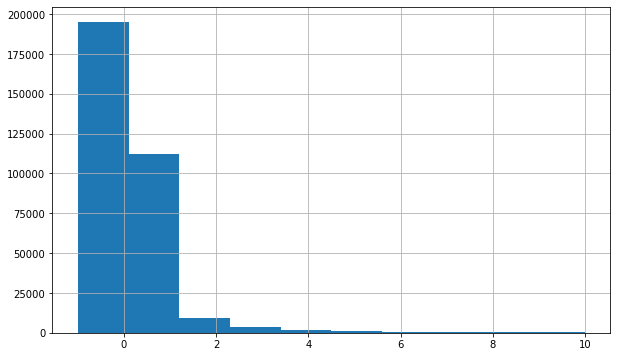

In [48]:
 # What explains such large inv?
compa[compa.inv<10].inv.hist() 

# Is Asset Growth Investment?

* See Cooper, Gulen, Schill, JF (2008);
* What is asset growth capturing other than investment? 
    * Mergers;
    * Issuance;
    * Spin-offs.
* Is it really investments that forecast future stock returns?

In [49]:
# A more traditional measure of investment: CAPX
compa['inv_capx'] = compa['capx']/compa['at_lag']
filter_inv_capx = (compa['capx']<=0)|(compa['at_lag']<=0)|(compa.fdiff>1)
compa.loc[filter_inv_capx,'inv_capx']=np.nan

<AxesSubplot:title={'center':"Apple's Investment"}, xlabel='fyear'>

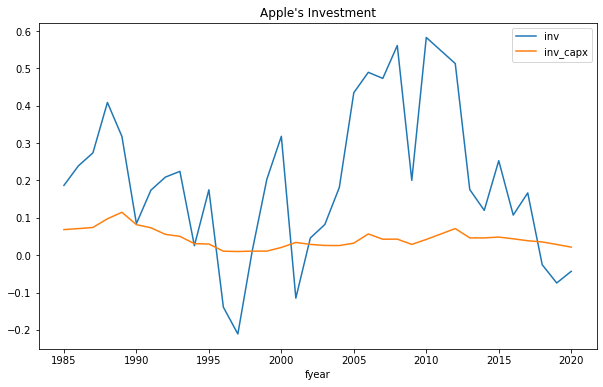

In [50]:
# Difference for Apple
compa.loc[(compa.gvkey=='001690')&
          (compa.fyear>=1985),['fyear','inv','inv_capx']
         ].set_index(['fyear']).plot(title="Apple's Investment") 

<AxesSubplot:title={'center':"Apple's Investment"}, xlabel='fyear'>

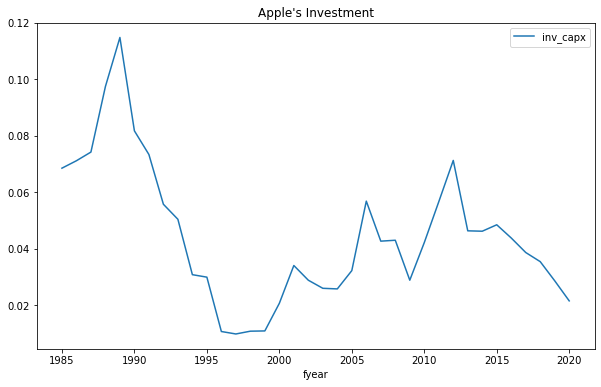

In [51]:
compa.loc[(compa.gvkey=='001690')&
          (compa.fyear>=1985),
          ['fyear','inv_capx']
         ].set_index(['fyear']).plot(title="Apple's Investment")

# Save Output

In [52]:
compa.columns

Index(['gvkey', 'datadate', 'conm', 'tic', 'cusip', 'fyear', 'fyr', 'at',
       'capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch', 'dltt', 'dp', 'ib',
       'itcb', 'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl',
       'pstkrv', 're', 'revt', 'sale', 'seq', 'sich', 'txdb', 'txdi', 'txditc',
       'wcapch', 'xint', 'xlr', 'xrd', 'xsga', 'se', 'ps', 'dt', 'be', 'cost',
       'op', 'opbe', 'at_lag', 'inv', 'fdiff', 'inv_capx'],
      dtype='object')

In [53]:
compa.to_pickle(path='/Users/liramertens/Dropbox/Columbia/BigData/class2021/lecture_outputs/compa_annual.pkl')